In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
from BehaviourFeatureExtractor import compute_speed, compute_head_angle_to_pup, compute_distance_to_pup, plot_mouse_angle_to_pup

## Reading and loading data ##

In [2]:
data_dir = "data"
DL = DataLoader(data_dir)

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

## Data Exploration ##

##### Day 1 trials #####

In [3]:
# get data for d1 experiment
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = "d1")

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']

<Axes: xlabel='pup_x'>

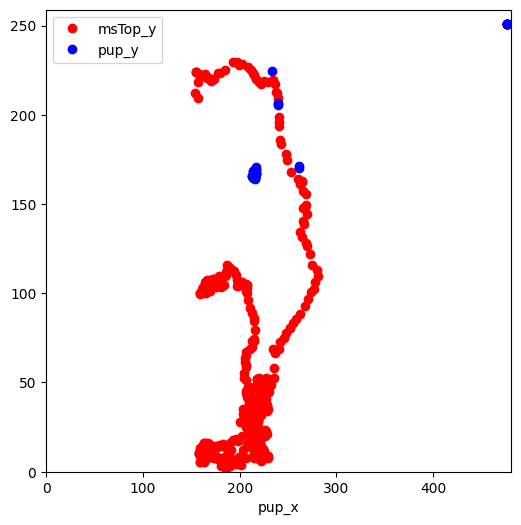

In [4]:
# create a grid of 1 x 2 plots
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ylim = max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())
xlim = max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max())

# color the points with the time
df_DLC.iloc[1000:1500].plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
df_DLC.iloc[1000:1500].plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')


In [5]:
df_summary.head(3)
# find dtype of each column
#df_summary.dtypes

,Group,AnimalID,ExptID,TrialNum,PupDisplPosition,BehavRecdTrialStartSecs,BehavRecdTrialEndSecs,PupDispDropSecs,MouseFirstPickUpPupSecs,DropPupNestSecs,TrialDesignAchieved,EndHabituation,OptoUsed,OptoStartSecs,OptoEndSecs,Features,Notes
0,M,MBI5335RR,d1,1,2,362.042,384.586,369.082,382.266,384.586,1,273.378,0,0,0,0,0
1,M,MBI5335RR,d1,2,3,390.098,402.842,396.698,399.682,402.842,1,273.378,0,0,0,0,0
2,M,MBI5335RR,d1,3,1,411.082,494.930,415.186,491.418,494.930,1,273.378,0,0,0,0,0


In [6]:
df_DLC.head(3)
#df_DLC["time_seconds"]*30

,frame_index,time_seconds,msTop_x,msTop_y,msTop_likelihood,endHeadbar_x,endHeadbar_y,endHeadbar_likelihood,earRight_x,earRight_y,...,tailBase_likelihood,nose_x,nose_y,nose_likelihood,centerNest_x,centerNest_y,centerNest_likelihood,pup_x,pup_y,pup_likelihood
151,151,5.033333,170.865509,89.811813,0.961542,190.735977,79.387955,0.943847,174.400299,80.521759,...,0.811119,169.054947,96.152382,0.965620,204.863220,57.566437,0.910896,477.403198,251.108810,0.074489
152,152,5.066667,170.884583,89.919662,0.960909,190.975998,79.499725,0.941302,174.574753,80.326324,...,0.806345,168.950119,96.181671,0.965517,204.960968,57.520256,0.904566,477.380341,251.101379,0.074293
153,153,5.100000,170.883240,90.323051,0.961621,191.376846,80.730232,0.936073,174.205078,80.630722,...,0.751888,169.327026,96.632072,0.967170,205.155075,57.570263,0.890773,477.362000,251.079193,0.073658


## Feature Extraction ##

### BehavSummary + DLC  ###

- **BehavSummary + DLC**
    - Define behavioral windows (e.g: -2 to +2 seconds of each behavioral event)
    - Define behavioral windows pre-event (e.g: -x to 0 seconds of each behavioral event)
    - Find behavioral events (from BehavSummaries; *timing info*) in the DLC position data (*x,y info*):
        - at each behavioral event, where was the mouse and the pup located in the arena?
            - how far was the mouse from the pup?
            - what was the head direction of the mouse (towards the pup) at that point?
            - ‘approach’ trajectory: parse out trajectory of mouse towards pup and try to find a segment which is more ‘direct’/ higher speed
        - For the pre-event behavioral window of MouseFirstPickUpSecs: what is the speed of the mouse? What is the head direction of the mouse?

In [7]:
trial_1 = df_summary[df_summary['TrialNum'] == 1]

trial_1

BehavRecdTrialEndSecs = trial_1['BehavRecdTrialEndSecs'].values[0]
PupDispDropSecs = trial_1['PupDispDropSecs'].values[0]
MouseFirstPickUpPupSecs = trial_1['MouseFirstPickUpPupSecs'].values[0]
DropPupNestSecs = trial_1['DropPupNestSecs'].values[0]
 
 # print all the times
print(BehavRecdTrialEndSecs, "frame index", BehavRecdTrialEndSecs*30, "int index", round(BehavRecdTrialEndSecs*30))
print(PupDispDropSecs, "frame index", PupDispDropSecs*30,"int index", round(PupDispDropSecs*30))
print(MouseFirstPickUpPupSecs, "frame index", MouseFirstPickUpPupSecs*30,"int index", round(MouseFirstPickUpPupSecs*30))
print(DropPupNestSecs, "frame index", DropPupNestSecs*30,"int index", round(DropPupNestSecs*30))

# compute frame indices by rounding
BehavRecdTrialEndSecs_frame = round(BehavRecdTrialEndSecs*30)
PupDispDropSecs_frame = round(PupDispDropSecs*30)
MouseFirstPickUpPupSecs_frame = round(MouseFirstPickUpPupSecs*30)
DropPupNestSecs_frame = round(DropPupNestSecs*30)

384.586 frame index 11537.58 int index 11538
369.082 frame index 11072.46 int index 11072
382.266 frame index 11467.980000000001 int index 11468
384.586 frame index 11537.58 int index 11538


In [8]:
# 2s is 60 frames
window_size = 60
start_frame_window = BehavRecdTrialEndSecs_frame - window_size
end_frame_window = BehavRecdTrialEndSecs_frame

# print corresponding time in minutes
print("Start time in seconds:", str(datetime.timedelta(seconds=start_frame_window/30)))
print("End time in seconds:", str(datetime.timedelta(seconds=end_frame_window/30)))

# look at the dataframe with frame_index within in the window
trial_1_DLC = df_DLC[df_DLC['frame_index'] >= start_frame_window][df_DLC['frame_index'] <= end_frame_window]

Start time in seconds: 0:06:22.600000
End time in seconds: 0:06:24.600000


/var/folders/ss/2547pfrs2tv5kkvqzk0wydg00000gn/T/ipykernel_18440/4221367034.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  trial_1_DLC = df_DLC[df_DLC['frame_index'] >= start_frame_window][df_DLC['frame_index'] <= end_frame_window]


<Axes: xlabel='pup_x'>

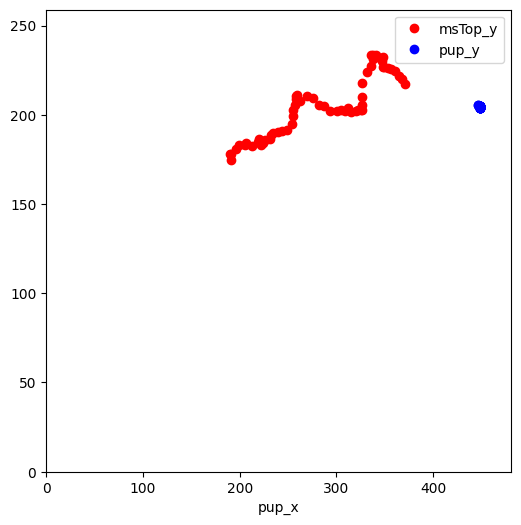

In [9]:
# plot mouse and pup positions
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

xlim, ylim =  max(df_DLC['msTop_x'].max(), df_DLC['pup_x'].max()), max(df_DLC['msTop_y'].max(), df_DLC['pup_y'].max())

trial_1_DLC.plot(x='msTop_x', y='msTop_y', style='o', ax=ax, xlim=(0, xlim), ylim=(0, ylim), color = 'r')
trial_1_DLC.plot(x='pup_x', y='pup_y', style='o', ax=ax,xlim=(0, xlim), ylim=(0, ylim), color = 'b')

Speed

Max speed: 241.5519362383066 Frame index: 11520.0 Time in minutes: 0:06:24


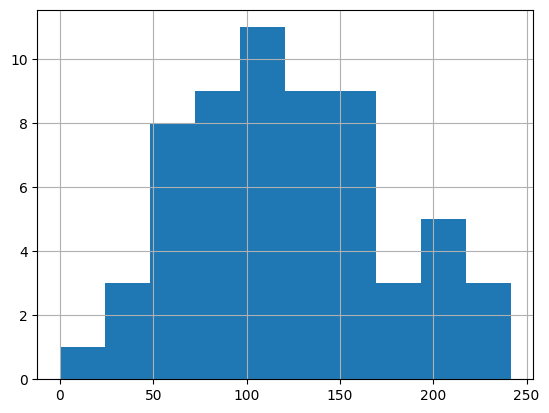

In [10]:
trial_1_DLC = compute_speed(trial_1_DLC)

# histogram of speed
trial_1_DLC['speed_cm/s'].hist()

# find point at which max speed is reached
max_speed = trial_1_DLC['speed_cm/s'].max()
max_speed_index = trial_1_DLC['speed_cm/s'].idxmax()

# find frame index and actual time in minutes
max_speed_frame_index = trial_1_DLC.loc[max_speed_index]['frame_index']
max_speed_time = trial_1_DLC.loc[max_speed_index]['time_seconds']
print("Max speed:", max_speed, "Frame index:", max_speed_frame_index, "Time in minutes:", str(datetime.timedelta(seconds=max_speed_time)))

Distance to pup

<Axes: >

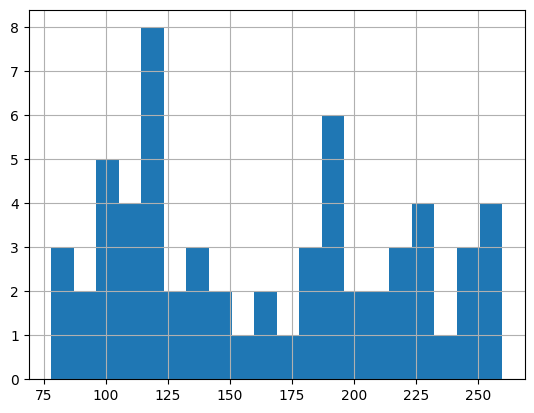

In [11]:
trial_1_DLC = compute_distance_to_pup(trial_1_DLC)

trial_1_DLC["distance_to_pup"].hist(bins=20)

Head angle to pup

<Axes: >

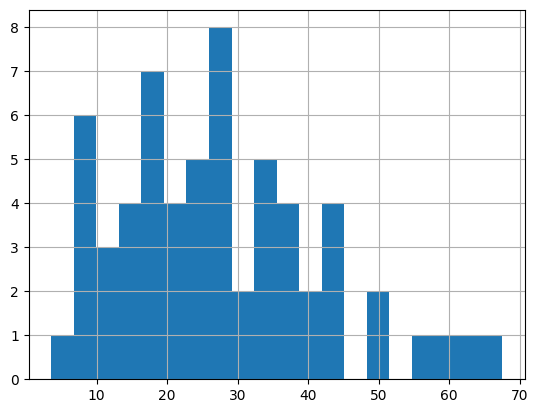

In [12]:
trial_1_DLC = compute_head_angle_to_pup(trial_1_DLC, add_vector_columns = True)

trial_1_DLC["head_angle_to_pup_degrees"].hist(bins=20)

Visualize head angle to pup

/Users/danaebroustail/Desktop/INI Project/Repos/Project/BehaviourFeatureExtractor.py:91: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([trial_1_DLC_frame['nose_x'].values[0], trial_1_DLC_frame['between_ears_x'].values[0]],
/Users/danaebroustail/Desktop/INI Project/Repos/Project/BehaviourFeatureExtractor.py:95: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([trial_1_DLC_frame['between_ears_x'].values[0], trial_1_DLC_frame['pup_x'].values[0]],


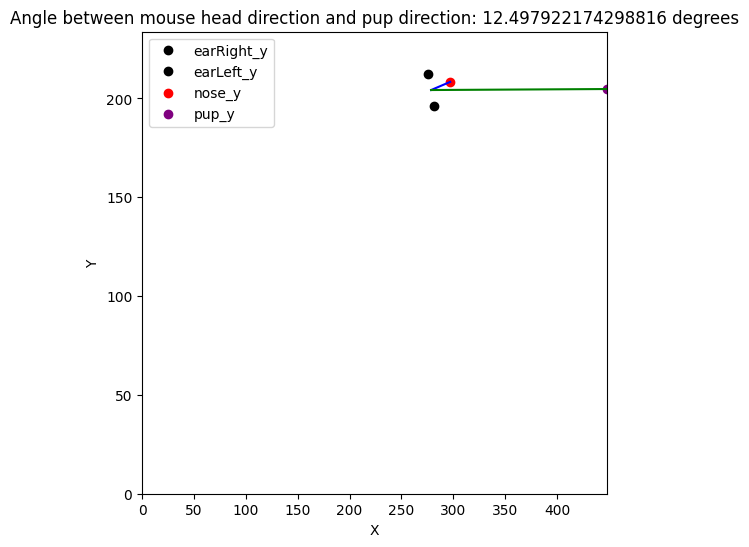

In [14]:
plot_mouse_angle_to_pup(trial_1_DLC)